In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
# from fpm_01 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


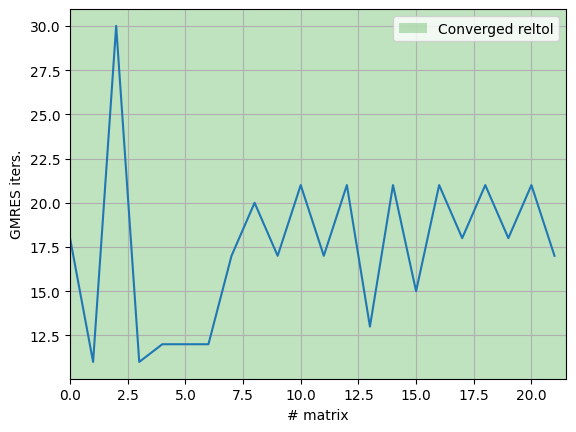

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

21

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 48
sliding = 0
open = 24
transition = 72
total = 72


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.18
True residual decrease: 5.759249688334358e-05


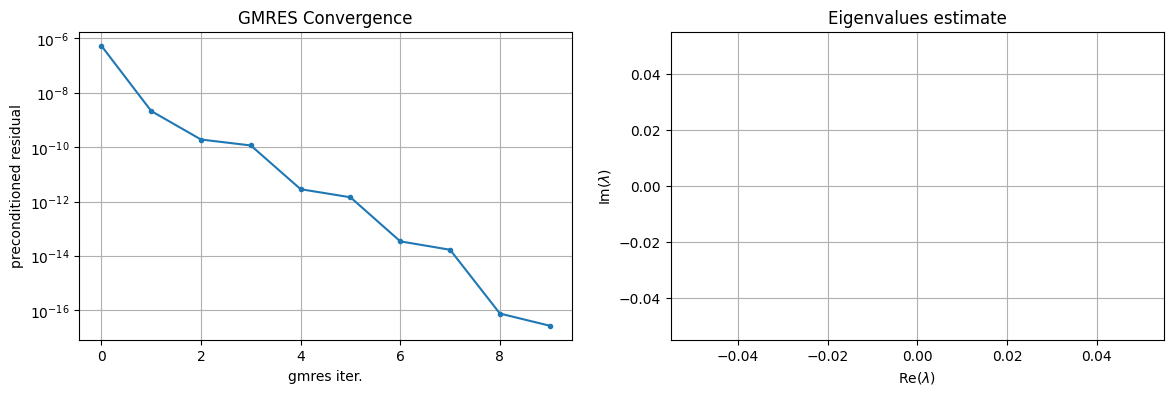

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

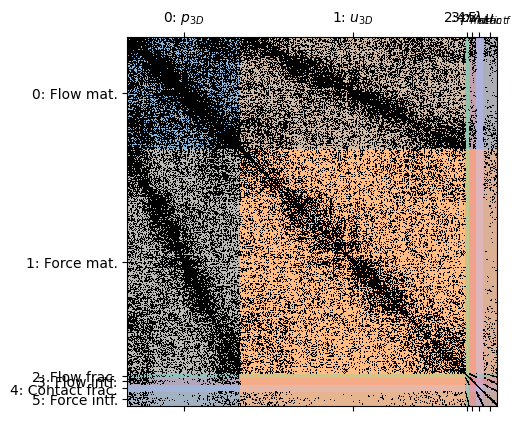

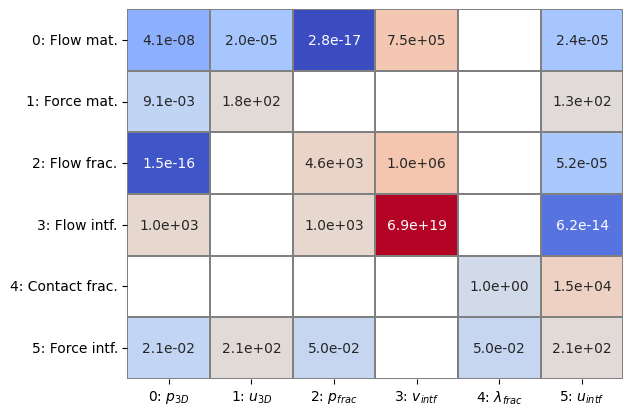

In [9]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

# Good one

Solve  took: 0.13
True residual decrease: 6.833849771511138e-16


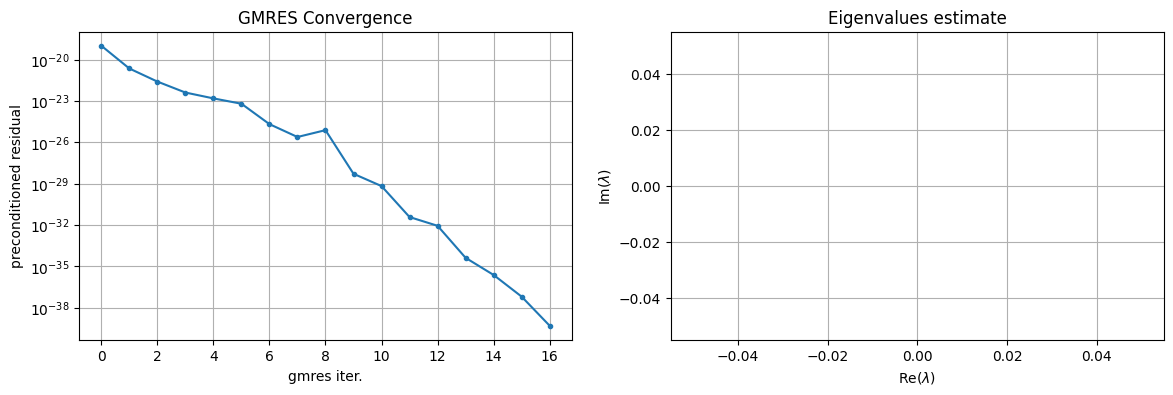

In [12]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-20)

Solve  took: 0.45
True residual decrease: 5.762264775607092e-06


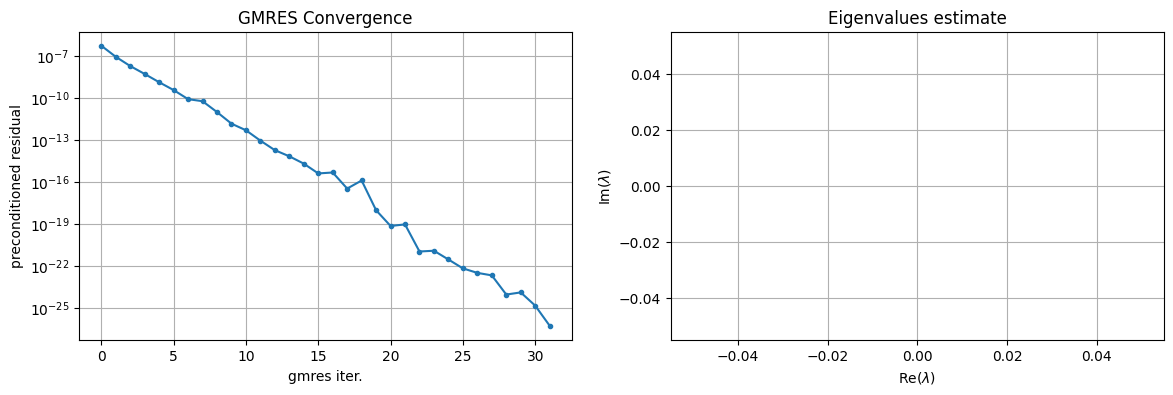

In [14]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(bmat[[3]].mat),
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-20)

# New stuff

In [48]:
class Minv:
    def __init__(self, J55_inv, J45):
        self.J55_inv = J55_inv
        self.J45 = J45
        nd = J55_inv.shape[0] + J45.shape[0]
        self.shape = nd, nd

    def dot(self, x):
        sep = self.J45.shape[0]
        x4 = x[:sep]
        x5 = x[sep:]
        res4 = 2 * x4 - self.J45 @ self.J55_inv.dot(x5)
        return np.concatenate([res4, x5])
    

class MultiplicativePrec:

    def __init__(self, first, second):
        self.first = first
        self.second = second
        assert first.shape == second.shape
        self.shape = first.shape

    def dot(self, x):
        tmp = self.first.dot(x)
        res = self.second.dot(tmp)
        return res
    
def make_new_prec(bmat):
    amg = PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd)
    M_inv = Minv(J55_inv=amg, J45=J[4, 5].mat)
    return MultiplicativePrec(first=M_inv, second=amg)

Solve  took: 0.0
True residual decrease: 5.5531601061613766e-12


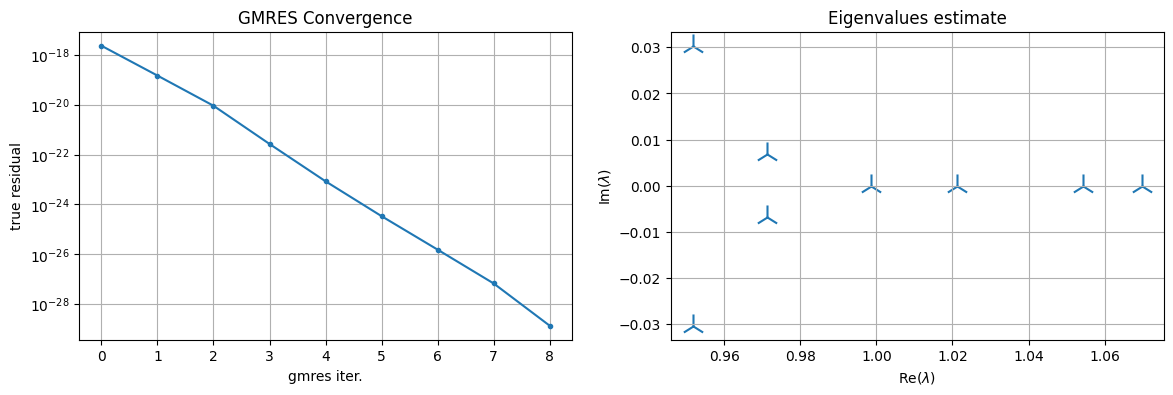

In [57]:
schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
        # solve=make_new_prec,
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
M_inv = Minv(J55_inv=PetscAMGMechanics(mat=J[[5]].mat, dim=model.nd), J45=J[4, [5]].mat)
mult_prec = MultiplicativePrec(first=M_inv, second=prec)

solve_petsc(mat_permuted.mat, mult_prec, mat_permuted.local_rhs(rhs), tol=1e-10, pc_side='right')

Solve  took: 0.0
True residual decrease: 1.620460128903575e-11


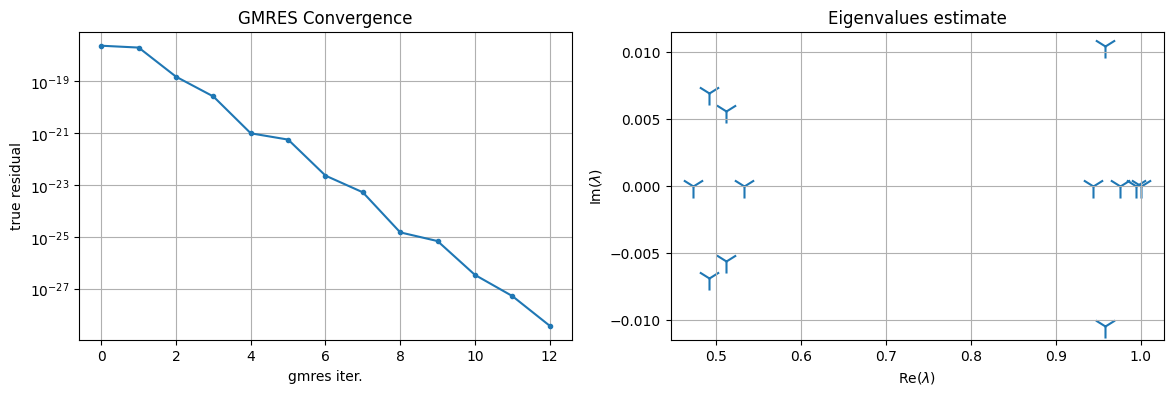

In [56]:
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-10, pc_side='right')